In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import shutil
import json
import pandas as pd
import cv2
from glob import glob
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

import sys
sys.path.append('/home/lea/trampo/MODELS_2D3D/mmpose')

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.utils import adapt_mmdet_pipeline

from mmdet.apis import DetInferencer

try:
    from mmdet.apis import inference_detector, init_detector
    has_mmdet = True
except (ImportError, ModuleNotFoundError):
    has_mmdet = False

from utils import predict_multiview_with_grad, find_best_triangulation, project_points, find_triangulation, show_keypoints_on_im

/home/lea/anaconda3/envs/multiview/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


### Set models parameters

In [2]:
# Set training parameters
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda' # FOR TESTING

LEARNING_RATE = 1e-5
BATCH_SIZE = 16
NUM_WORKERS = 4
N = 8 # number of cameras
K = 17 # number of keypoints

# Init detector
det_config = '/home/lea/trampo/MODELS_2D3D/mmpose/demo/mmdetection_cfg/rtmdet_m_640-8xb32_coco-person.py'
det_checkpoint = 'https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth'
#det_config = "/home/lea/trampo/MODELS_2D3D/rtmpose/RTMPose/rtmdet_nano_320-8xb32_coco-person.py" 
#det_checkpoint = "/home/lea/trampo/MODELS_2D3D/rtmpose/RTMPose/rtmdet_nano_8xb32-100e_coco-obj365-person-05d8511e.pth"
det_model= init_detector(det_config, det_checkpoint, device=device)
det_model.cfg = adapt_mmdet_pipeline(det_model.cfg)

# Init pose model
pose_config = '/home/lea/trampo/MODELS_2D3D/mmpose/configs/body_2d_keypoint/rtmpose/body8/rtmpose-m_8xb256-420e_body8-256x192.py'
pose_checkpoint = 'https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-body7_pt-body7_420e-256x192-e48f03d0_20230504.pth'
#pose_config = "/home/lea/trampo/MODELS_2D3D/rtmpose/RTMPose/rtmpose-l_8xb256-420e_coco-256x192.py"  
#pose_checkpoint = "/home/lea/trampo/MODELS_2D3D/rtmpose/RTMPose/rtmpose-l_simcc-aic-coco_pt-aic-coco_420e-256x192-f016ffe0_20230126.pth"
pose_model = init_pose_estimator(pose_config, pose_checkpoint, device=device)
pose_model.train()

# Unfreeze all parameters
for param in pose_model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.Adam(pose_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

/home/lea/anaconda3/envs/multiview/lib/python3.10/importlib/__init__.py:169: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  _bootstrap._exec(spec, module)


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-body7_pt-body7_420e-256x192-e48f03d0_20230504.pth


### Prepare data

In [3]:
root_dir = '/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Images_trampo_avril2025/20250429'
data_dir = '/home/lea/trampo/MODELS_2D3D/finetuning_multiview/dataset'

sequences = set([str(f).split('-')[0] for f in os.listdir(root_dir)])

sequences = sorted([seq for seq in sequences if seq[0] in ['1', '2']])

cameras = ['Camera1_M11139', 'Camera2_M11140', 'Camera3_M11141', 'Camera4_M11458',
           'Camera5_M11459', 'Camera6_M11461', 'Camera7_M11462', 'Camera8_M11463']

K = np.load('calib/K.npz')['arr_0']
Ks = torch.tensor(K, dtype=torch.float32, device=device)

D = np.load('calib/D.npz')['arr_0']

""" for seq in sequences:
    if not os.path.isdir(os.path.join(data_dir, seq)):
        os.makedirs(os.path.join(data_dir, seq))
    for cam in cameras:
        dest_dir = os.path.join(data_dir, seq, cam)
        source_dir = os.path.join(root_dir, seq+'-'+cam)
        shutil.copytree(source_dir, dest_dir) """

" for seq in sequences:\n    if not os.path.isdir(os.path.join(data_dir, seq)):\n        os.makedirs(os.path.join(data_dir, seq))\n    for cam in cameras:\n        dest_dir = os.path.join(data_dir, seq, cam)\n        source_dir = os.path.join(root_dir, seq+'-'+cam)\n        shutil.copytree(source_dir, dest_dir) "

In [4]:
# inventaire athlète/frame/caméra/seq
error_thresh = 500
person_dist_thresh = 500  # distance threshold to discard mismatched persons

dataset_path = '/home/lea/trampo/MODELS_2D3D/finetuning_multiview/dataset'
detections = []

""" 
for seq in os.listdir(dataset_path):
    person_id = int(str(seq).split('_')[0])

    session = str(seq).split('-')[0].split('_')[2]
    calib_path = os.path.join('calib', f'WorldTCam_{session}.npz')
    world_T_cam = np.load(calib_path)['arr_0']
    projMat = np.stack([np.linalg.inv(mat) for mat in world_T_cam])
    Ts = torch.tensor(projMat, dtype=torch.float32, device=device).unsqueeze(0)
    
    for frame in tqdm(sorted(list(os.listdir(os.path.join(dataset_path, seq, 'Camera1_M11139'))))):
        frame_nb = int(str(frame).split('_')[1].split('.')[0])

        images = []
        for cam in os.listdir(os.path.join(dataset_path, seq)):
            cam_idx = int(str(cam)[6]) - 1
            img_path = os.path.join(dataset_path, seq, cam, frame)
            img = cv2.imread(img_path)
            img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
            images.append(img)
        images = torch.stack(images).unsqueeze(0)

        with torch.no_grad():
            keypoints = predict_multiview_with_grad(det_model, pose_model, images, bbox_thr=0.3, pose_batch_size=8, training=False)
            error, preds_2d, points_3d = find_triangulation(keypoints, Ks, Ts, error_thresh)
        
        if torch.isnan(points_3d).all():
            continue

        # Reproject and add cameras to cams_on if error is below error_thresh
        Rt = Ts[:, :, :3, :]
        P_all = Ks @ Rt
        reproj, valid_mask = project_points(points_3d, P_all)

        dist = torch.norm(preds_2d - reproj, dim=-1).view(8, 17)  # Euclidean distance
        keep_mask = (dist < person_dist_thresh).all(dim=1)
        
        if keep_mask.sum() == 0:
            continue
        cams_on_all = keep_mask
        
        for cam_i, cam_on in enumerate(cams_on_all.squeeze()):
            if cam_on:
                #print((seq, cam_i, frame_nb, person_id))
                detections.append((seq, cam_i, frame_nb, person_id))

df = pd.DataFrame(detections)
df.columns = ["seq", "cam", "frame", "person"]
df.to_pickle("detections.pkl")

print(df) """

' \nfor seq in os.listdir(dataset_path):\n    person_id = int(str(seq).split(\'_\')[0])\n\n    session = str(seq).split(\'-\')[0].split(\'_\')[2]\n    calib_path = os.path.join(\'calib\', f\'WorldTCam_{session}.npz\')\n    world_T_cam = np.load(calib_path)[\'arr_0\']\n    projMat = np.stack([np.linalg.inv(mat) for mat in world_T_cam])\n    Ts = torch.tensor(projMat, dtype=torch.float32, device=device).unsqueeze(0)\n    \n    for frame in tqdm(sorted(list(os.listdir(os.path.join(dataset_path, seq, \'Camera1_M11139\'))))):\n        frame_nb = int(str(frame).split(\'_\')[1].split(\'.\')[0])\n\n        images = []\n        for cam in os.listdir(os.path.join(dataset_path, seq)):\n            cam_idx = int(str(cam)[6]) - 1\n            img_path = os.path.join(dataset_path, seq, cam, frame)\n            img = cv2.imread(img_path)\n            img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0\n            images.append(img)\n        images = torch.stack(images).unsqueeze(0)\n\n     

### Create dataset + dataloader

In [5]:
class MultiViewDataset(Dataset):
    def __init__(self, root_dir, K, transform=None, detections_file=None):
        self.root_dir = root_dir
        self.transform = transform

        # Discover all sequences
        sequences = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.sequences = sorted(sequences)
        
        self.sequence_data = []  # Will hold (seq_name, frame_names, calibration)
        self.index_map = []      # Global index -> (seq_idx, frame_idx)

        if detections_file:
            self.detections = pd.read_pickle(detections_file)
        else:
            self.detections = True

        for seq_idx, seq_name in enumerate(self.sequences):
            seq_path = os.path.join(root_dir, seq_name)

            # Load calibration for this sequence
            session = seq_name.split('-')[0].split('_')[2]
            calib_path = os.path.join('calib', f'WorldTCam_{session}.npz')

            world_T_cam = np.load(calib_path)['arr_0']
            projMat = np.stack([np.linalg.inv(mat) for mat in world_T_cam])

            Ts = torch.tensor(projMat, dtype=torch.float32)
            Ks = torch.tensor(K, dtype=torch.float32)

            # Get camera dirs
            cam_dirs = sorted([d for d in os.listdir(seq_path) if d.startswith("Cam")])
            cam_dirs = [os.path.join(seq_path, d) for d in cam_dirs]
            self.cam_dirs = cam_dirs

            # Get frames from first camera (assume sync)
            frame_names = sorted(os.listdir(cam_dirs[0]))

            # Store metadata for this sequence
            self.sequence_data.append({
                "name": seq_name,
                "cam_dirs": cam_dirs,
                "frame_names": frame_names,
                "Ks": Ks,
                "Ts": Ts
            })

            # Build global index mapping
            for frame_idx in range(len(frame_names)):
                self.index_map.append((seq_idx, frame_idx))

        self.num_views = len(self.cam_dirs)

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        seq_idx, frame_idx = self.index_map[idx]
        seq_info = self.sequence_data[seq_idx]

        Ks, Ts = seq_info["Ks"], seq_info["Ts"]
        frame_name = seq_info["frame_names"][frame_idx]
        seq_name = seq_info["name"]

        images = []
        detected = []
        df = self.detections.copy()

        for cam_idx, cam_dir in enumerate(seq_info["cam_dirs"]):
            img_path = os.path.join(cam_dir, frame_name)
            img = cv2.imread(img_path)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.transform:
                img = self.transform(image=img)['image']
            else:
                img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
            images.append(img)

            frame_idx = int(str(frame_name).split('_')[1].split('.')[0])

            if isinstance(self.detections, pd.DataFrame):
                detection = ((df['seq'] == seq_name) &
                            (df['cam'] == cam_idx) &
                            (df['frame'] == frame_idx)).any()
                detection = bool(detection)  # convert np.bool_ → Python bool
            else:
                detection = True  # or False, depending on your intended logic
            athlete_detected = torch.tensor(detection, dtype=torch.bool)
            detected.append(athlete_detected)

        detected = torch.stack(detected, dim=0)
        images = torch.stack(images, dim=0)  # (V,C,H,W)

        return {
            "images": images,  # (V,C,H,W)
            "Ks": Ks,
            "Ts": Ts,
            "seq_name": seq_name,
            "frame_idx": frame_idx,
            "detected": detected,
        }
    
# Dataloader
dataset = MultiViewDataset(root_dir=data_dir, K=K, transform=None, detections_file='detections.pkl')

print(len(dataset))  # total number of frames across all sequences

train_size = int(0.8 * len(dataset))
val_size   = int(0.1 * len(dataset))
test_size  = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # reproducible split
)

sample = dataset[0]
print(sample.keys())
print(sample["images"].shape)  # (V, C, H, W)
print(sample["Ks"].shape)      # (V, 3, 3)
print(sample["Ts"].shape)      # (V, 4, 4)
print(sample["seq_name"], sample["frame_idx"], sample["detected"])

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, persistent_workers=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, persistent_workers=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

2645
dict_keys(['images', 'Ks', 'Ts', 'seq_name', 'frame_idx', 'detected'])
torch.Size([8, 3, 1080, 1920])
torch.Size([8, 3, 3])
torch.Size([8, 4, 4])
1_partie_0429 0 tensor([False,  True,  True, False,  True,  True, False,  True])


### Bone length loss

In [6]:
seg_lengths = [(1, 290, 230, 440, 330),
               (2, 285, 260, 520, 360),
               (3, 310, 230, 520, 370),
               (4, 285, 250, 520, 350),
               (5, 340, 270, 540, 420),
               (6, 390, 270, 530, 370),
               (7, 300, 240, 450, 350)]

map_seg_to_keypoints = [(2, 3), (3, 4), (9, 10), (10, 11), (5, 6), (6, 7), (12, 13), (13, 14)]

df = pd.DataFrame(seg_lengths)
df.columns = ["id", "shoulder-elbow", "elbow-wrist", "hip-knee", "knee-ankle"]
df.to_pickle("seg_lengths.pkl")
print(df)

def get_loss_bones(seg_lengths, keypoints, map):
    loss = 0
    for side in range(2):
        for i, l in enumerate(seg_lengths):
            pair = map[side][i]
            loss += abs(l - torch.linalg.norm(keypoints[pair[0]] - keypoints[pair[1]]))
    return loss/8

import torch

def bone_length_loss(keypoints, seg_lengths, map_seg_to_keypoints, device=None):
    """
    keypoints: Tensor [B, N, D]  (D=2 or 3)
    seg_lengths: list of per-bone target lengths (float)
    map_seg_to_keypoints: list of tuples [(i,j), (k,l), ...]
    """
    # Convert to tensors
    map_seg = torch.tensor(map_seg_to_keypoints, device=device)
    target_lengths = seg_lengths #, device=keypoints.device, dtype=torch.float32)

    # Extract coordinates for bone endpoints
    kp1 = keypoints[:, map_seg[:, 0], :]  # [B, n_bones, D]
    kp2 = keypoints[:, map_seg[:, 1], :]  # [B, n_bones, D]

    # Compute bone lengths per sample
    bone_lengths = torch.linalg.norm(kp1 - kp2, dim=-1)  # [B, n_bones]

    # Compute loss (L2 difference)
    loss = torch.nanmean(torch.abs(bone_lengths - target_lengths))
    return loss


   id  shoulder-elbow  elbow-wrist  hip-knee  knee-ankle
0   1             290          230       440         330
1   2             285          260       520         360
2   3             310          230       520         370
3   4             285          250       520         350
4   5             340          270       540         420
5   6             390          270       530         370
6   7             300          240       450         350


### Train + validate

In [ ]:
import time

# Create a log directory (TensorBoard will read from this)
writer = SummaryWriter(log_dir="runs/bones01")
print("TensorBoard log dir:", writer.log_dir)

error_thresh = 500
person_dist_thresh = 100
torch.set_printoptions(precision=4, sci_mode=False)

os.makedirs("checkpoints", exist_ok=True)

num_epochs = 5
global_step = 0
lambda_bones = 0.1
best_val_loss = float('inf')

seg_lengths = pd.read_pickle("seg_lengths.pkl")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    pose_model.train()

    for step, batch in enumerate(train_loader):
        start_total = time.perf_counter()
        optimizer.zero_grad()

        # --- 0. Data transfer ---
        t0 = time.perf_counter()
        images, Ks, Ts, seq, frames, detections = batch.values()
        images = images.to(device, non_blocking=True)
        Ks = Ks.to(device, non_blocking=True)
        Ts = Ts.to(device, non_blocking=True)
        detections = detections.to(device, non_blocking=True)
        id = 1
        seg_l_id = seg_lengths.loc[seg_lengths['id'] == id].iloc[0, 1:].to_numpy()
        seg_l_tensor = torch.tensor(seg_l_id, dtype=torch.float32, device=device)
        seg_l_tensor = torch.cat([seg_l_tensor, seg_l_tensor])
        t1 = time.perf_counter()

        # --- 1. Predict 2D keypoints ---
        t2 = time.perf_counter()
        keypoints = predict_multiview_with_grad(
            det_model, pose_model, images, device=device,
            bbox_thr=0.3, training=True, detections=detections)
        t3 = time.perf_counter()

        # --- 2. Triangulate ---
        error, preds_2d, points_3d, cams_on = find_best_triangulation(keypoints, Ks, Ts, error_thresh)
        t4 = time.perf_counter()
        if torch.isnan(points_3d).all():
            continue

        # --- 3. Reprojection ---
        Rt = Ts[:, :, :3, :]
        P_all = Ks @ Rt
        reproj, valid_mask = project_points(points_3d, P_all)
        t5 = time.perf_counter()

        # --- 4. Filtering ---
        preds_valid = preds_2d[valid_mask]
        reproj_valid = reproj[valid_mask]
        dist = torch.norm(preds_valid - reproj_valid, dim=-1)
        keep_mask = dist < person_dist_thresh
        if keep_mask.sum() == 0:
            continue
        preds_valid = preds_valid[keep_mask]
        reproj_valid = reproj_valid[keep_mask]
        t6 = time.perf_counter()

        # --- 5. Losses ---
        loss_reproj = torch.sqrt(torch.nn.functional.mse_loss(preds_valid, reproj_valid))
        loss_bones = bone_length_loss(points_3d, seg_l_tensor, map_seg_to_keypoints)
        loss = loss_reproj + lambda_bones * loss_bones
        t7 = time.perf_counter()

        # --- 6. Backprop ---
        loss.backward()
        optimizer.step()
        t8 = time.perf_counter()

        if global_step % 5 == 0:
            writer.add_scalar("Train/Loss_reproj", loss_reproj.item(), global_step)
            writer.add_scalar("Train/Loss_bones", loss_bones.item(), global_step)
            writer.add_scalar("Train/Loss", loss.item(), global_step)
            writer.add_scalar("Train/Triangulation_error", torch.nanmean(error).item(), global_step)
        global_step += 1

        if step % 20 == 0:
            images_np = images.cpu().detach().numpy()[0]
            pts_d = preds_2d.cpu().detach().numpy()[0]
            pts_r = reproj.cpu().detach().numpy()[0]
            show_keypoints_on_im(images_np, pts_d, pts_r, f'viz/epoch{epoch+1}_it{step}', show=False)

        # --- Timing summary ---
        total_time = t8 - start_total
        print(
            f"[Step {step}] "
            f"Data: {t1 - t0:.3f}s | "
            f"Predict: {t3 - t2:.3f}s | "
            f"Triangulate: {t4 - t3:.3f}s | "
            f"Reproject: {t5 - t4:.3f}s | "
            f"Filter: {t6 - t5:.3f}s | "
            f"Loss: {t7 - t6:.3f}s | "
            f"Backprop: {t8 - t7:.3f}s | "
            f"Total: {total_time:.3f}s"
        )

     # --- VALIDATION ---
    pose_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_batch in val_loader:
            images, Ks, Ts, seq, frames, detections = val_batch.values()
            images = images.to(device, non_blocking=True)
            Ks = Ks.to(device, non_blocking=True)
            Ts = Ts.to(device, non_blocking=True)
            detections = detections.to(device, non_blocking=True)
            
            # --- 1. Predict 2D keypoints for detected views ---
            keypoints = predict_multiview_with_grad(
                det_model, pose_model, images, device=device,
                bbox_thr=0.3, training=True, detections=detections)
            
            # --- 2. Triangulate (batched) ---
            error, preds_2d, points_3d, cams_on = find_best_triangulation(keypoints, Ks, Ts, error_thresh)
            if torch.isnan(points_3d).all():
                continue

            # --- 3. Reproject 3D back into each view ---
            Rt = Ts[:, :, :3, :]
            P_all = Ks @ Rt
            reproj, valid_mask = project_points(points_3d, P_all)
            preds_valid = preds_2d[valid_mask]
            reproj_valid = reproj[valid_mask]

            # --- 4. Remove mismatched persons (dist > 100) ---
            dist = torch.norm(preds_valid - reproj_valid, dim=-1)  # Euclidean distance
            keep_mask = dist < person_dist_thresh
            if keep_mask.sum() == 0:
                continue
            preds_valid = preds_valid[keep_mask]
            reproj_valid = reproj_valid[keep_mask]

            val_loss_batch = torch.sqrt(torch.nn.functional.mse_loss(preds_valid, reproj_valid))
            val_loss += val_loss_batch.item()

    val_loss /= len(val_loader)
    writer.add_scalar("Val/Loss", val_loss, epoch)

    # --- Save checkpoint (optional: only best) ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': pose_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, "checkpoints/best_model.pth")

    # Save checkpoint every epoch
    ckpt_path = f"checkpoints/epoch_{epoch+1}.pth"
    torch.save({ 
        'epoch': epoch + 1,
        'model_state_dict': pose_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
    }, ckpt_path)
    print(f"✅ Saved checkpoint: {ckpt_path}")

writer.close()

# TODO IDEA : per-camera loss for view-specific pose estimator

TensorBoard log dir: runs/bones01

Epoch 1/5


/home/lea/anaconda3/envs/multiview/lib/python3.10/site-packages/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/lea/anaconda3/envs/multiview/lib/python3.10/site-packages/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/lea/anaconda3/envs/multiview/lib/python3.10/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[Step 0] Data: 1.726s | Predict: 5.916s | Triangulate: 1.110s | Reproject: 0.000s | Filter: 0.000s | Loss: 0.006s | Backprop: 0.201s | Total: 8.960s
[Step 1] Data: 1.545s | Predict: 4.543s | Triangulate: 1.732s | Reproject: 0.000s | Filter: 0.000s | Loss: 0.000s | Backprop: 0.114s | Total: 7.935s
[Step 2] Data: 1.753s | Predict: 4.538s | Triangulate: 1.138s | Reproject: 0.000s | Filter: 0.000s | Loss: 0.001s | Backprop: 0.098s | Total: 7.529s
[Step 3] Data: 1.508s | Predict: 4.227s | Triangulate: 0.668s | Reproject: 0.000s | Filter: 0.000s | Loss: 0.001s | Backprop: 0.102s | Total: 6.507s
[Step 4] Data: 1.651s | Predict: 4.118s | Triangulate: 0.549s | Reproject: 0.000s | Filter: 0.000s | Loss: 0.001s | Backprop: 0.089s | Total: 6.410s
[Step 5] Data: 1.554s | Predict: 4.735s | Triangulate: 0.966s | Reproject: 0.000s | Filter: 0.000s | Loss: 0.001s | Backprop: 0.109s | Total: 7.366s
[Step 6] Data: 1.764s | Predict: 4.249s | Triangulate: 0.848s | Reproject: 0.000s | Filter: 0.000s | Loss:

KeyboardInterrupt: 

### Test

In [ ]:
checkpoint = torch.load("checkpoints/epoch_1.pth", map_location=device)
pose_model.load_state_dict(checkpoint['model_state_dict'])
pose_model.eval()

test_loss = 0.0
with torch.no_grad():
    for batch in test_loader:
        images, Ks, Ts, seq, frames, detections = batch.values()
        images = images.to(device, non_blocking=True)
        Ks = Ks.to(device, non_blocking=True)
        Ts = Ts.to(device, non_blocking=True)
        detections = detections.to(device, non_blocking=True)

        # --- 1. Predict 2D keypoints for detected views ---
        keypoints = predict_multiview_with_grad(
            det_model, pose_model, images, device=device,
            bbox_thr=0.3, training=True, detections=detections)
        
        # --- 2. Triangulate (batched) ---
        error, preds_2d, points_3d, cams_on = find_best_triangulation(keypoints, Ks, Ts, error_thresh)
        if torch.isnan(points_3d).all():
            continue

        # --- 3. Reproject 3D back into each view ---
        Rt = Ts[:, :, :3, :]
        P_all = Ks @ Rt
        reproj, valid_mask = project_points(points_3d, P_all)
        preds_valid = preds_2d[valid_mask]
        reproj_valid = reproj[valid_mask]

        # --- 4. Remove mismatched persons (dist > 100) ---
        dist = torch.norm(preds_valid - reproj_valid, dim=-1)  # Euclidean distance
        keep_mask = dist < person_dist_thresh
        if keep_mask.sum() == 0:
            continue
        preds_valid = preds_valid[keep_mask]
        reproj_valid = reproj_valid[keep_mask]

        loss_batch = torch.sqrt(torch.nn.functional.mse_loss(preds_valid, reproj_valid))
        test_loss += loss_batch.item()

test_loss /= len(test_loader)
print(f"✅ Final test RMSE: {test_loss:.4f}")


KeyboardInterrupt: 

### Show keypoints on images

(8, 3, 1080, 1920) (8, 17, 2) (8, 17, 2)


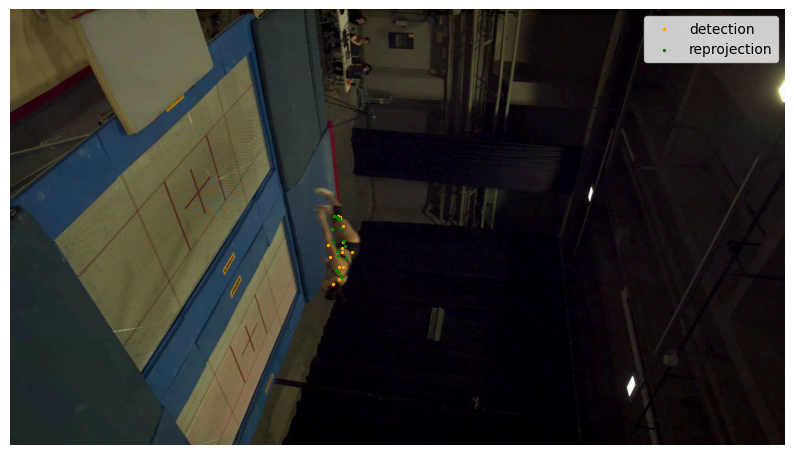

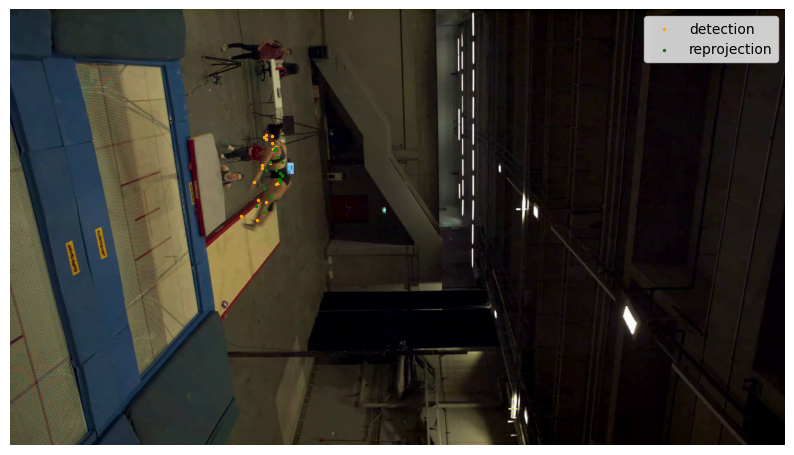

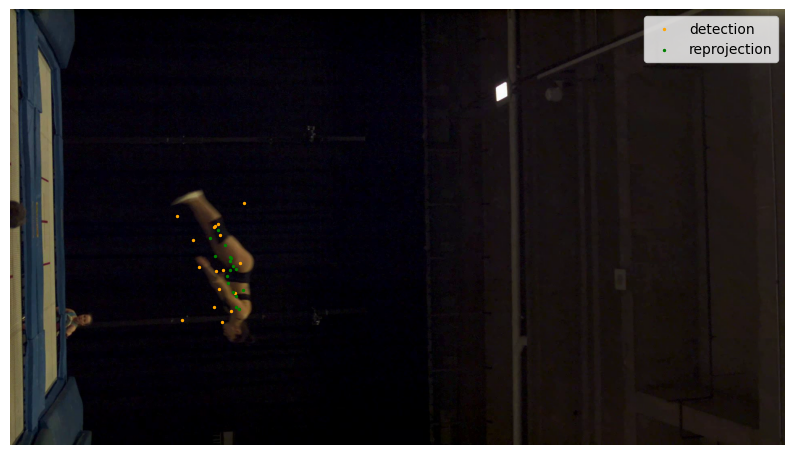

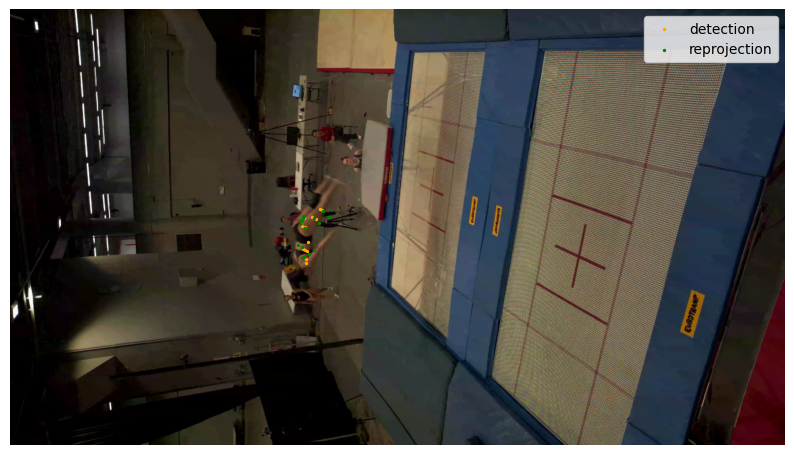

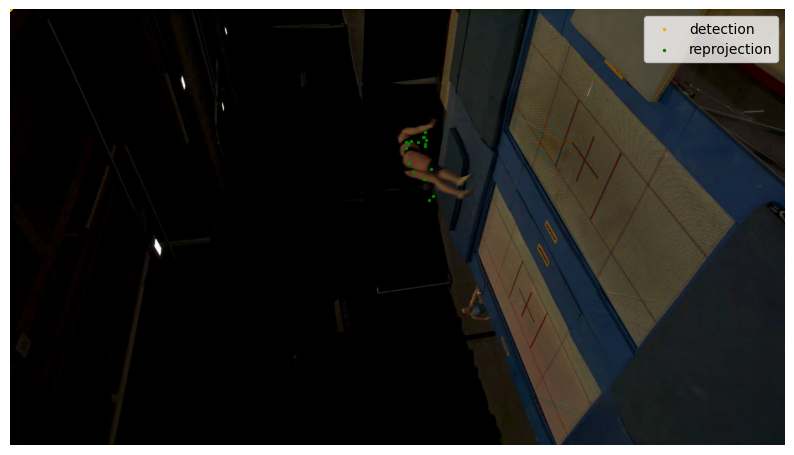

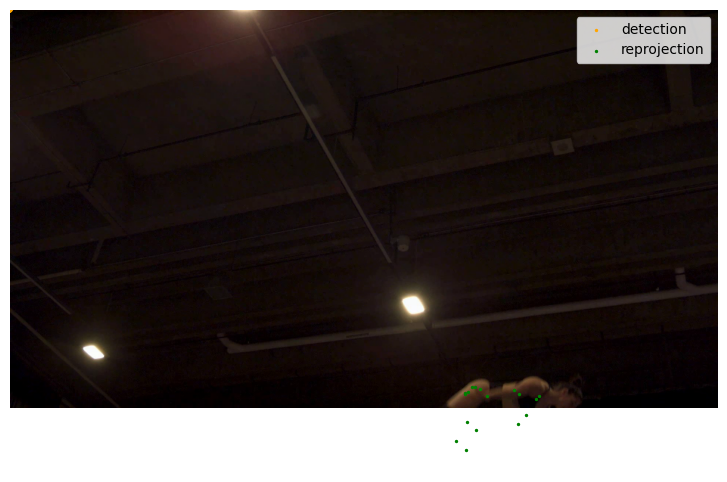

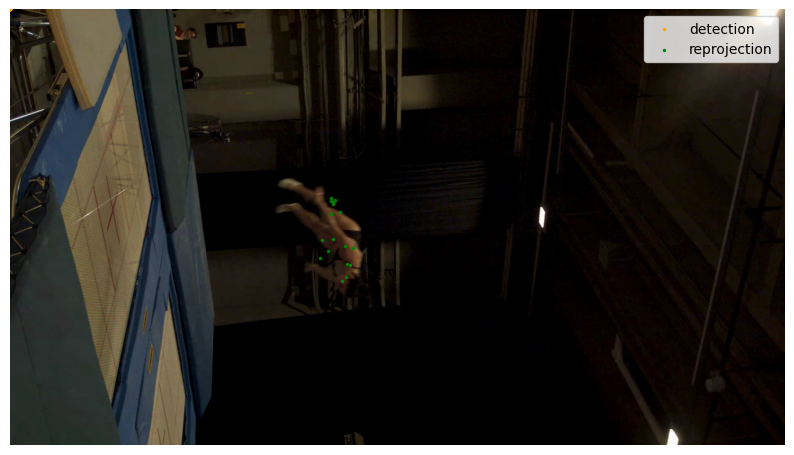

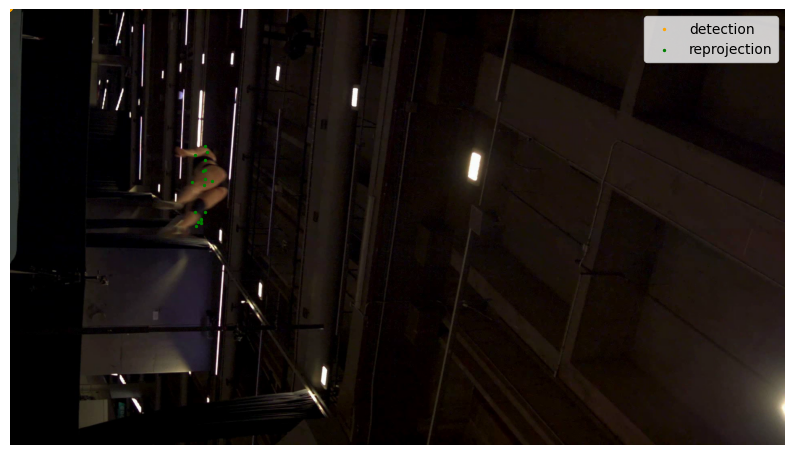

In [ ]:
b = 0

images_np = images.cpu().detach().numpy()[b]
pts_d = preds_2d.cpu().detach().numpy()[b]
pts_r = reproj.cpu().detach().numpy()[b]

print(images_np.shape, pts_d.shape, pts_r.shape)

show_keypoints_on_im(images_np, pts_d, pts_r, 'viz/epoch1', show=True)

## Test detectors

In [ ]:
import cv2
import matplotlib.patches as patches

def plot_bbox_on_image(image, bboxes):
    fig, ax = plt.subplots()
    ax.imshow(image)  # show image
    for bbox in bboxes:
        x, y = bbox[0], bbox[1]
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]

        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x, y), width, height,
            linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [ ]:
model = YOLO("yolo11l.pt")

path = '/home/lea/trampo/MODELS_2D3D/finetuning_multiview/dataset/1_partie_0429_003/Camera2_M11140'
im_files = os.listdir(path)

det = 0
for i, im_file in tqdm(enumerate(im_files)):
    im_name = os.path.join(path, im_file)
    results = model(im_name, classes=[0], conf=0.3, verbose=False)
    bboxes = results[0].boxes.xyxy
    det += len(bboxes)

    if i % 100 == 0:
        plot_bbox_on_image(cv2.imread(im_name), bboxes.cpu().numpy())
    """ 
    if len(bboxes) > 0:
        print(bboxes)

    for result in results:  # peut contenir plusieurs images
        boxes = result.boxes  # toutes les bbox
        for box in boxes:
            cls = int(box.cls[0])          # classe prédite (0 = person dans COCO)
            conf = float(box.conf[0])      # score de confiance
            xyxy = box.xyxy[0].tolist()    # coordonnées [x1, y1, x2, y2] """  

print(det)

## Versions

In [ ]:
import mmdet, mmpose, mmengine, mmcv

print("Torch CUDA:", torch.version.cuda)
print("Torch device:", torch.cuda.get_device_name(0))
x = torch.ones(1, device='cuda')
print("CUDA test OK:", x.device)

print("MMCV:", mmcv.__version__)
print("MMDetection:", mmdet.__version__)
print("MMPose:", mmpose.__version__)
print("MMEngine:", mmengine.__version__)

#print(type(img_np), img_np.shape if hasattr(img_np, "shape") else None)
print(det_model.__class__)
print(det_model.cfg.test_dataloader.dataset.pipeline)

Torch CUDA: 12.8
Torch device: NVIDIA GeForce RTX 4090
CUDA test OK: cuda:0
MMCV: 2.1.0
MMDetection: 3.3.0
MMPose: 1.3.2
MMEngine: 0.10.7
<class 'mmdet.models.detectors.rtmdet.RTMDet'>
[{'type': 'mmdet.LoadImageFromNDArray', 'backend_args': None}, {'type': 'mmdet.Resize', 'scale': (640, 640), 'keep_ratio': True}, {'type': 'mmdet.Pad', 'size': (640, 640), 'pad_val': {'img': (114, 114, 114)}}, {'type': 'mmdet.LoadAnnotations', 'with_bbox': True}, {'type': 'mmdet.PackDetInputs', 'meta_keys': ('img_id', 'img_path', 'ori_shape', 'img_shape', 'scale_factor')}]
